To build a classification model that can predict the authenticity of banknotes and deploy it using streamlit library

In [ ]:
!pip -q install pyspark flasgger

In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from pyspark.sql import SparkSession, functions as f
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.master('local[2]').appName('BankNoteAuthentication').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/19 07:07:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
from google.colab import files
files.upload()

Saving BankNote_Authentication.csv to BankNote_Authentication (1).csv


{'BankNote_Authentication.csv': b'variance,skewness,curtosis,entropy,class\r\n3.6216,8.6661,-2.8073,-0.44699,0\r\n4.5459,8.1674,-2.4586,-1.4621,0\r\n3.866,-2.6383,1.9242,0.10645,0\r\n3.4566,9.5228,-4.0112,-3.5944,0\r\n0.32924,-4.4552,4.5718,-0.9888,0\r\n4.3684,9.6718,-3.9606,-3.1625,0\r\n3.5912,3.0129,0.72888,0.56421,0\r\n2.0922,-6.81,8.4636,-0.60216,0\r\n3.2032,5.7588,-0.75345,-0.61251,0\r\n1.5356,9.1772,-2.2718,-0.73535,0\r\n1.2247,8.7779,-2.2135,-0.80647,0\r\n3.9899,-2.7066,2.3946,0.86291,0\r\n1.8993,7.6625,0.15394,-3.1108,0\r\n-1.5768,10.843,2.5462,-2.9362,0\r\n3.404,8.7261,-2.9915,-0.57242,0\r\n4.6765,-3.3895,3.4896,1.4771,0\r\n2.6719,3.0646,0.37158,0.58619,0\r\n0.80355,2.8473,4.3439,0.6017,0\r\n1.4479,-4.8794,8.3428,-2.1086,0\r\n5.2423,11.0272,-4.353,-4.1013,0\r\n5.7867,7.8902,-2.6196,-0.48708,0\r\n0.3292,-4.4552,4.5718,-0.9888,0\r\n3.9362,10.1622,-3.8235,-4.0172,0\r\n0.93584,8.8855,-1.6831,-1.6599,0\r\n4.4338,9.887,-4.6795,-3.7483,0\r\n0.7057,-5.4981,8.3368,-2.8715,0\r\n1.1432,-

In [ ]:
df = spark.read.csv('BankNote_Authentication.csv',inferSchema=True, header=True)

In [ ]:
df.head()

Row(variance=3.6216, skewness=8.6661, curtosis=-2.8073, entropy=-0.44699, class=0)

In [ ]:
df.show(5)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
|  3.4566|  9.5228| -4.0112| -3.5944|    0|
| 0.32924| -4.4552|  4.5718| -0.9888|    0|
+--------+--------+--------+--------+-----+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- variance: double (nullable = true)
 |-- skewness: double (nullable = true)
 |-- curtosis: double (nullable = true)
 |-- entropy: double (nullable = true)
 |-- class: integer (nullable = true)



In [ ]:
#Looking for null values
df.select([f.sum(f.isnan(f.col(c)).cast('int')).alias(f'null_{c}') for c in df.columns]).show()

+-------------+-------------+-------------+------------+----------+
|null_variance|null_skewness|null_curtosis|null_entropy|null_class|
+-------------+-------------+-------------+------------+----------+
|            0|            0|            0|           0|         0|
+-------------+-------------+-------------+------------+----------+



We can see that the dataset has no null values

In [ ]:
#Printing the shape of dataset
print("(",df.count(),",",len(df.columns),")")

( 1372 , 5 )


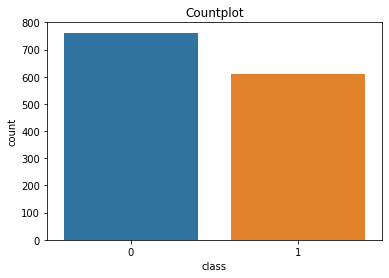

In [ ]:
#Plotting the countplot of the available classes
data = df.select('class').toPandas()
sns.countplot(data=data,x='class')
_=plt.title("Countplot")

We can see that both the classes have nearly equal count making the dataset balanced

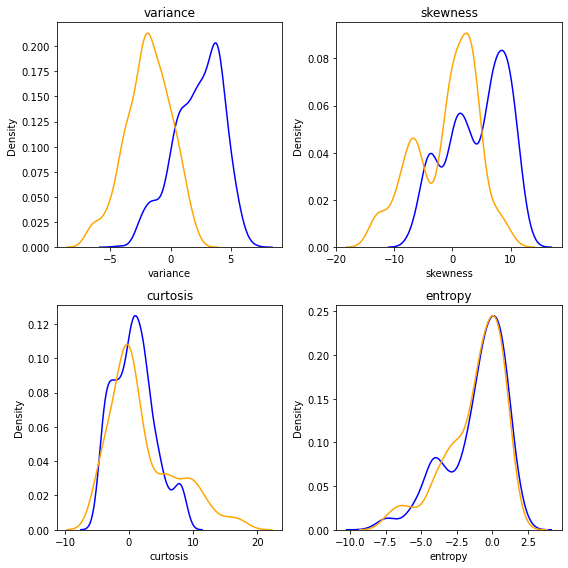

In [ ]:
#Performing separation of dataset as per class for plotting
data_0=df.where(f.col("class")==0)
data_1=df.where(f.col("class")==1)

#Making the KDE plots
cols = df.columns
cols.remove('class')
fig,ax =plt.subplots(2,2,figsize=(8,8))
for feature,axes in zip(cols,ax.ravel()):
    sns.kdeplot(data_0.select(feature).toPandas()[feature],color='blue',ax=axes)
    sns.kdeplot(data_1.select(feature).toPandas()[feature],color='orange',ax=axes)
    axes.set_title(feature)
plt.tight_layout()

We can see from the plot that Variance is the important feature which helps us the most to differentiate between the classes. While Entropy gives almost the similar plot for both the classes

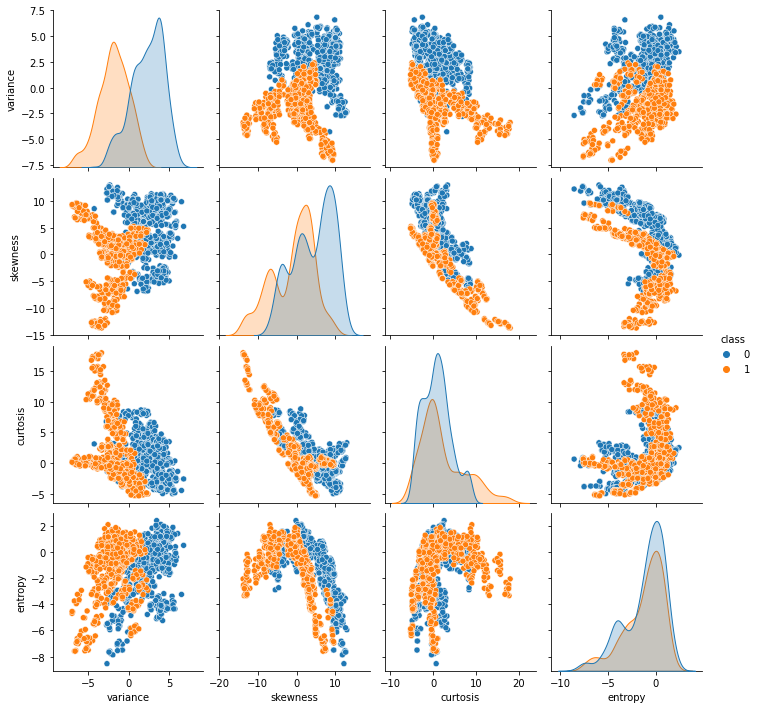

In [ ]:
#Plotting a Pairplot of the classes
data = df.toPandas()
sns.pairplot(data=data,hue='class')

We can notice the most differeniation in the Variance plot of the two classes. While Curtosis and Entropy plot shows the lowest differentiation between the two classes

In [ ]:
#Displaying the dataframe
df.show(5)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
|  3.6216|  8.6661| -2.8073|-0.44699|    0|
|  4.5459|  8.1674| -2.4586| -1.4621|    0|
|   3.866| -2.6383|  1.9242| 0.10645|    0|
|  3.4566|  9.5228| -4.0112| -3.5944|    0|
| 0.32924| -4.4552|  4.5718| -0.9888|    0|
+--------+--------+--------+--------+-----+
only showing top 5 rows



In [ ]:
#Creating a Feature column using VectorAssembler
#Importing VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [ ]:
#Naming 'cols' as the list of feature names that we are having
print(cols)

['variance', 'skewness', 'curtosis', 'entropy']


In [ ]:
VecAssembler = VectorAssembler(inputCols=cols,outputCol="features")
VecAssembler.transform(df).select("features","class").show(5)

+--------------------+-----+
|            features|class|
+--------------------+-----+
|[3.6216,8.6661,-2...|    0|
|[4.5459,8.1674,-2...|    0|
|[3.866,-2.6383,1....|    0|
|[3.4566,9.5228,-4...|    0|
|[0.32924,-4.4552,...|    0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
#Choosing 0.7 as the training split length. We have used Randomsplit method to do the same.
train,test = df.randomSplit([0.7,0.3])

In [ ]:
#Scaling the features using StandardScaler 
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [ ]:
scaler = StandardScaler(inputCol="features",outputCol="features_scaled")

#Transforming the datasets using pipeline
feature_pipe = Pipeline(stages=[VecAssembler,scaler]).fit(train)
train = feature_pipe.transform(train)
test = feature_pipe.transform(test)

In [ ]:
train.select("features","features_scaled").show(5)

+--------------------+--------------------+
|            features|     features_scaled|
+--------------------+--------------------+
|[-7.0364,9.2931,0...|[-2.4272566099251...|
|[-6.7526,8.8172,-...|[-2.3293577659286...|
|[-6.651,6.7934,0....|[-2.2943101177607...|
|[-6.5773,6.8017,0...|[-2.2688867745524...|
|[-6.5235,9.6014,-...|[-2.2503280789674...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#Performing PCA decomposition
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

In [ ]:
pca = PCA(k=3,inputCol="features",outputCol="pca").fit(train)
data = pca.transform(train).select("pca","class")
data.show(5)

21/12/19 07:08:43 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/12/19 07:08:43 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


+--------------------+-----+
|                 pca|class|
+--------------------+-----+
|[-7.0137192126666...|    1|
|[-6.6811814105078...|    1|
|[-5.2045268634812...|    1|
|[-5.1208051540394...|    1|
|[-7.9191844802750...|    1|
+--------------------+-----+
only showing top 5 rows



In [ ]:
data = data.withColumn("pca",vector_to_array("pca")).select(f.col("class"),f.col("pca")[0],f.col("pca")[1],f.col("pca")[2])
data.show(5)

+-----+------------------+-------------------+-------------------+
|class|            pca[0]|             pca[1]|             pca[2]|
+-----+------------------+-------------------+-------------------+
|    1|-7.013719212666619|-10.198695680967905| -1.501135280948183|
|    1|-6.681181410507881| -9.423834699218073|-1.2236941971883901|
|    1|-5.204526863481296|-10.703176174535667|-0.8939188052395024|
|    1|-5.120805154039426|-10.668508391192955|-1.0608107576527974|
|    1|-7.919184480275031|-10.803110848897791|-1.5145027096366492|
+-----+------------------+-------------------+-------------------+
only showing top 5 rows



In [ ]:
#Printing a 3D Scatterplot of the PCA features
data = data.toPandas()

In [ ]:
fig = px.scatter_3d(data, x='pca[0]', y='pca[1]', z='pca[2]',color='class',title="3D Scatterplot of PCA Features",color_continuous_scale=px.colors.sequential.Viridis)
fig.update(layout_coloraxis_showscale=False)
fig.show()

With the help of PCA, we reduce the number of features from 4 to 3 for there visualization. Now using Logistic Regression and Support Vector Classifier for making of the model.

In [ ]:
#LogisticRegression model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
logr = LogisticRegression(featuresCol="features",labelCol="class",predictionCol='prediction_logr')
params = ParamGridBuilder().addGrid(logr.maxIter,[50,75,100,150,200]).addGrid(logr.regParam,[0,0.0001,0.001,0.01,0.1,0.5]).build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_logr',labelCol='class',metricName='f1')
CValidator = CrossValidator(estimator=logr,estimatorParamMaps=params,evaluator=evaluator,numFolds=5)
CValidator_logr = CValidator.fit(train)

#predictions on test data
predictions_logr= CValidator_logr.transform(test).select('prediction_logr','class')
predictions_logr.show(5)

+---------------+-----+
|prediction_logr|class|
+---------------+-----+
|            1.0|    1|
|            1.0|    1|
|            1.0|    1|
|            1.0|    1|
|            1.0|    1|
+---------------+-----+
only showing top 5 rows



/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Area under the ROC curve: 0.9999
F1 Score: 0.9758
Accuracy: 0.9758


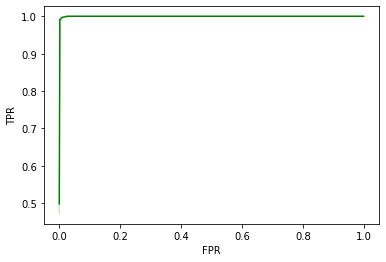

In [ ]:
#Plotting the ROC curve
data = CValidator_logr.bestModel.summary.roc.toPandas()
sns.lineplot(data=data,x='FPR',y='TPR',color='green')
print("Area under the ROC curve:",format(CValidator_logr.bestModel.summary.areaUnderROC,'.4f'))
print("F1 Score:",format(evaluator.evaluate(predictions_logr),'.4f'))
evaluator.setMetricName('accuracy')
print("Accuracy:",format(evaluator.evaluate(predictions_logr),'.4f'))

From Logistic Regression Model we get an accuracy of 97.5% for our dataset

In [ ]:
#Support Vector Classifier Model
from pyspark.ml.classification import LinearSVC

In [ ]:
svc = LinearSVC(featuresCol='features_scaled',labelCol='class',predictionCol='prediction_svc')
params = ParamGridBuilder().addGrid(svc.maxIter,[100,150,200]).addGrid(svc.regParam,[0,0.001,1]).build()
evaluator.setPredictionCol('prediction_svc')
evaluator.setMetricName('f1')

CValidator_svc = CrossValidator(estimator=svc,estimatorParamMaps=params,evaluator=evaluator).fit(train)

21/12/19 07:12:20 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:12:25 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:12:27 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:12:53 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:12:57 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:12:58 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:13:24 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:13:29 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:13:30 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:13:58 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:13:58 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
21/12/19 07:14:02 ERROR OWLQN: F

In [ ]:
predictions_svc = CValidator_svc.transform(test).select("prediction_svc","class")

In [ ]:
print("f1 Score",format(evaluator.evaluate(predictions_svc),'.4f'))
evaluator.setMetricName('accuracy')
print("Accuracy score: ",format(evaluator.evaluate(predictions_svc),'.4f'))

f1 Score 0.9812
Accuracy score:  0.9812


From Support Vector Classifier Model we get an accuracy of 98% for our dataset

Using StreamLit library

In [ ]:
!pip -q install streamlit

In [ ]:
!pip install ipykernel>=5.1.2
!pip install pydeck

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml.pipeline import PipelineModel
import streamlit as st

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LinearSVCModel
from pyspark.ml.pipeline import PipelineModel

In [ ]:
#Load feature_pipe and model

feature_pipe = PipelineModel.load('feature_pipe')
model = LinearSVCModel.load('bank_note_model_svc')
spark = SparkSession.builder.master('local').appName('deployPyspark').getOrCreate()

def predict(variance,skewness,curtosis,entropy,spark):
    schema = "variance FLOAT, skewness FLOAT, curtosis FLOAT, entropy FLOAT"
    data = spark.createDataFrame([[variance,skewness,curtosis,entropy]],schema=schema)
    data = feature_pipe.transform(data)
    prediction = model.transform(data).select("prediction_svc").collect()[0][0]
    return "Fake Note" if(prediction) else "Authentic Note"
    
def noteAuth():
    st.title("Bank Note Authentication")
    st.markdown("Application for predicting the authenticity of Bank Notes")

    variance = float(st.text_input("Variance", 3.6216))
    skewness = float(st.text_input("Skewness",8.6661))
    curtosis = float(st.text_input("Curtosis",-2.8073))
    entropy = float(st.text_input("Entropy",-0.44699))

    if(st.button("Predict")):
        result = predict(variance,skewness,curtosis,entropy,spark)
        st.success(f"Prediction: {result}")

if __name__ == '__main__':
    noteAuth()

2021-12-19 07:19:30.530 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]
